In [3]:
import mne 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Посмотрим на данные

Extracting EDF parameters from /home/flypew/Programming/Hackathons/ElectrocorticogramClassification/data/ECoG_fully_marked_(4+2 files, 6 h each)/Ati4x3_12m_BL_6h_fully_marked.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8640399  =      0.000 ... 21600.998 secs...


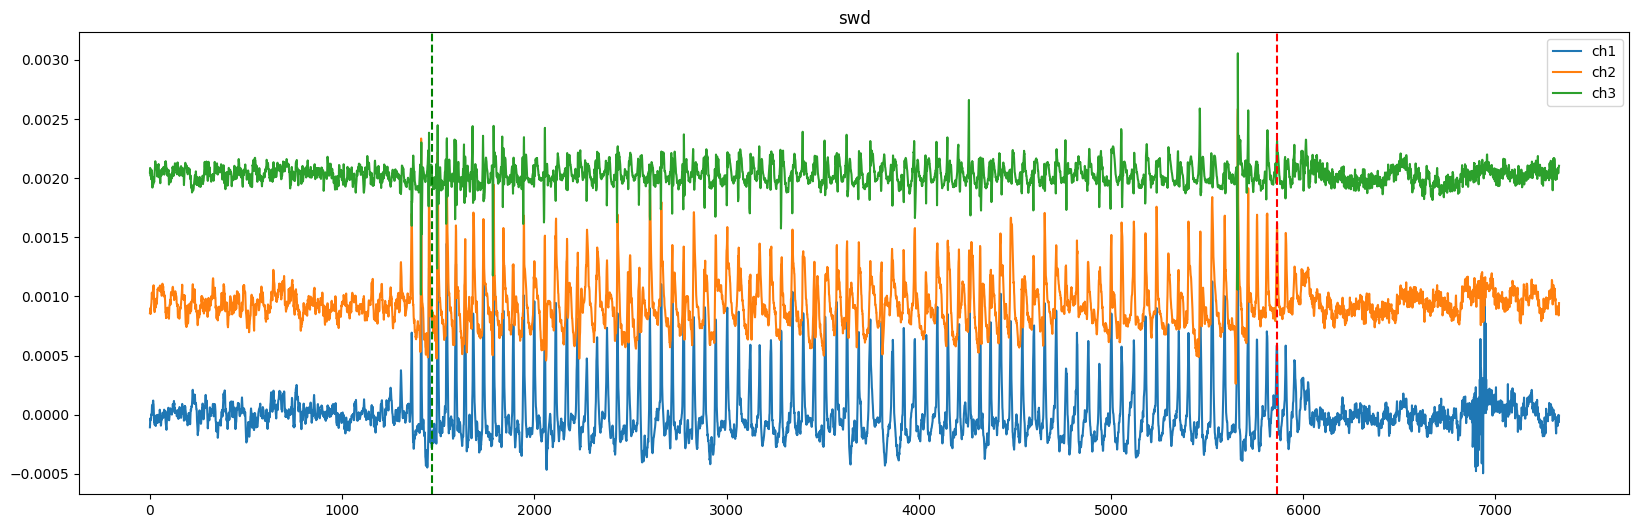

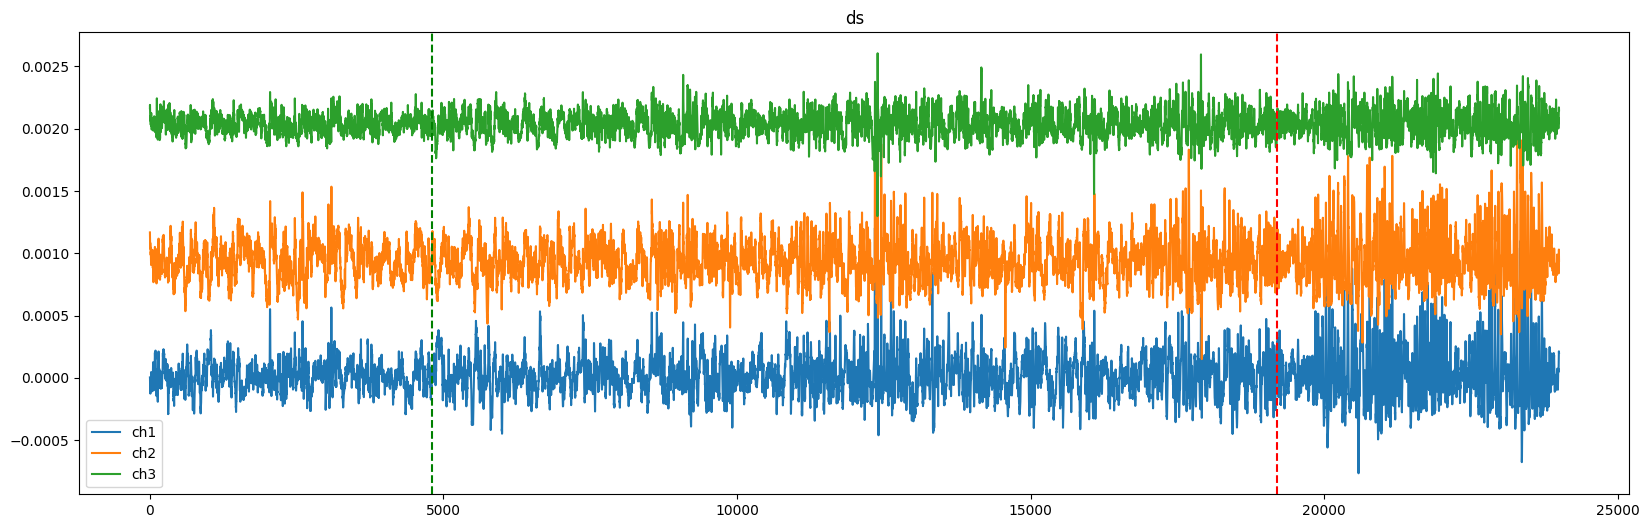

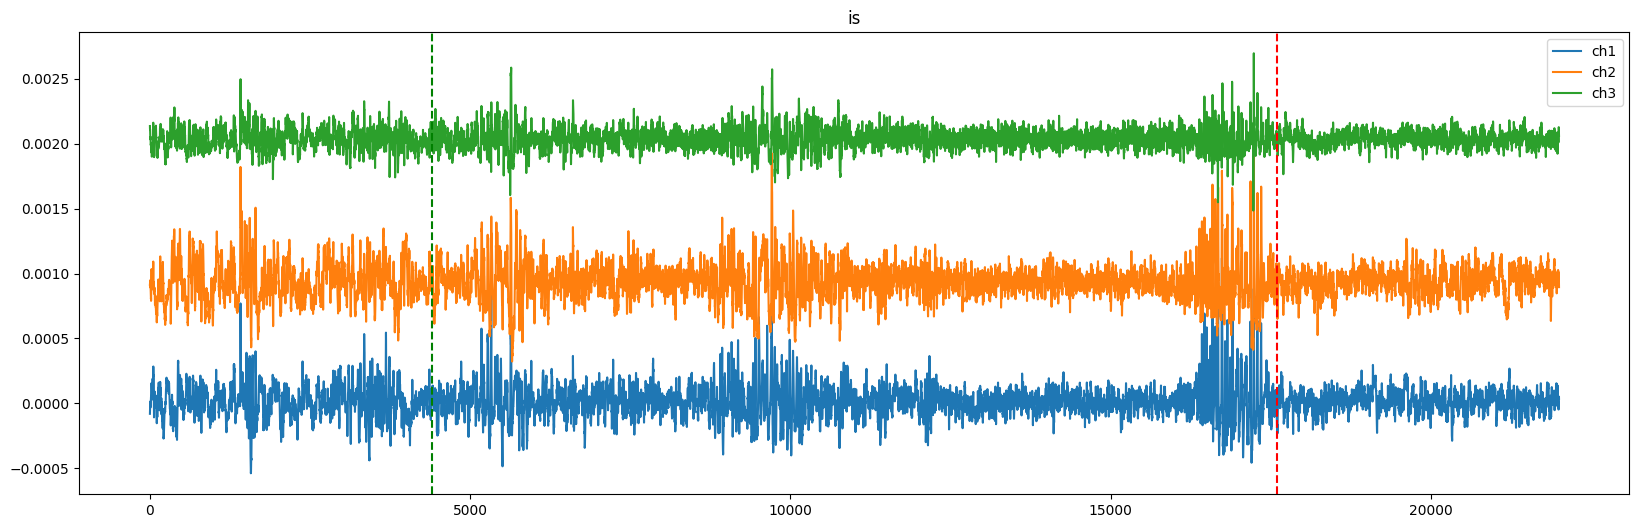

In [4]:
from load_data import get_data_and_annotations
from random import choice

filepath = 'data/ECoG_fully_marked_(4+2 files, 6 h each)/Ati4x3_12m_BL_6h_fully_marked.edf'
raw = mne.io.read_raw_edf(filepath, preload=True)
data = raw.get_data()
_, annotations = get_data_and_annotations(raw)

event_types = ['swd', 'ds', 'is']

for event_type in event_types:
    event = choice(annotations[event_type])
    start = event[0]
    end = event[1]
    margin = (end-start)//3
    data_slice = data[:, start-margin:end+margin]
    
    ch1 = data_slice[0]
    ch2 = data_slice[1] + 0.001
    ch3 = data_slice[2] + 0.002
    plt.figure(figsize=(20, 6))
    plt.plot(ch1, label='ch1')
    plt.plot(ch2, label='ch2')
    plt.plot(ch3, label='ch3')
    plt.axvline(margin, color='g', linestyle='--')
    plt.axvline(len(ch1)-margin, color='r', linestyle='--')
    plt.legend()
    plt.title(event_type)
    plt.show()

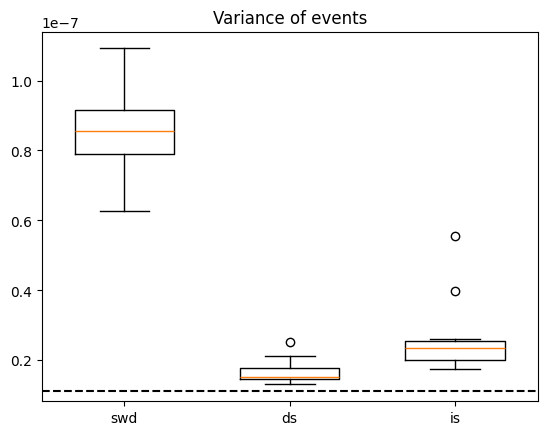

In [5]:
variances_dict = {}

for event_type in event_types:
    event_list = annotations[event_type]
    variances = []
    
    for event in event_list:
        start = event[0]
        end = event[1]
        data_slice = data[0, start:end]
        variances.append(np.var(data_slice))
    
    variances_dict[event_type] = variances

plt.boxplot(variances_dict['swd'], positions=[1], widths=0.6)
plt.boxplot(variances_dict['ds'], positions=[2], widths=0.6)
plt.boxplot(variances_dict['is'], positions=[3], widths=0.6)
plt.axhline(np.var(data[0]), color='k', linestyle='--')
plt.xticks([1, 2, 3], ['swd', 'ds', 'is'])
plt.title('Variance of events')
plt.show()

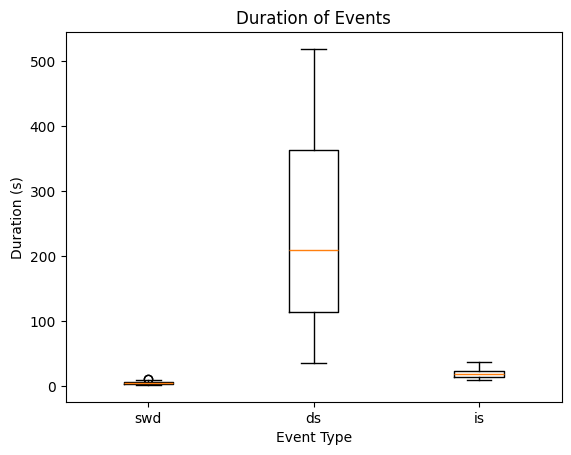

In [6]:
event_durations = {}

for event_type in event_types:
    event_list = annotations[event_type]
    durations = []
    
    for event in event_list:
        duration = event[1] - event[0]
        durations.append(duration / 400)
    
    event_durations[event_type] = durations

plt.boxplot(event_durations.values(), tick_labels=event_durations.keys())
plt.xlabel('Event Type')
plt.ylabel('Duration (s)')
plt.title('Duration of Events')
plt.show()

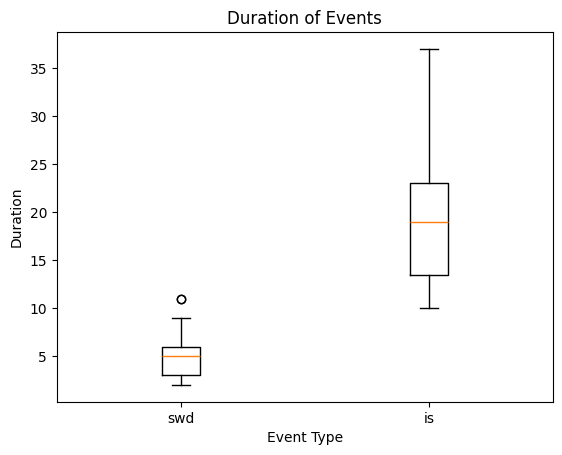

In [7]:
event_durations = {}

for event_type in event_types:
    if event_type == "ds":
        continue
    event_list = annotations[event_type]
    durations = []
    
    for event in event_list:
        duration = event[1] - event[0]
        durations.append(duration / 400)
    
    event_durations[event_type] = durations

plt.boxplot(event_durations.values(), tick_labels=event_durations.keys())
plt.xlabel('Event Type')
plt.ylabel('Duration')
plt.title('Duration of Events')
plt.show()

# Спектрограммы

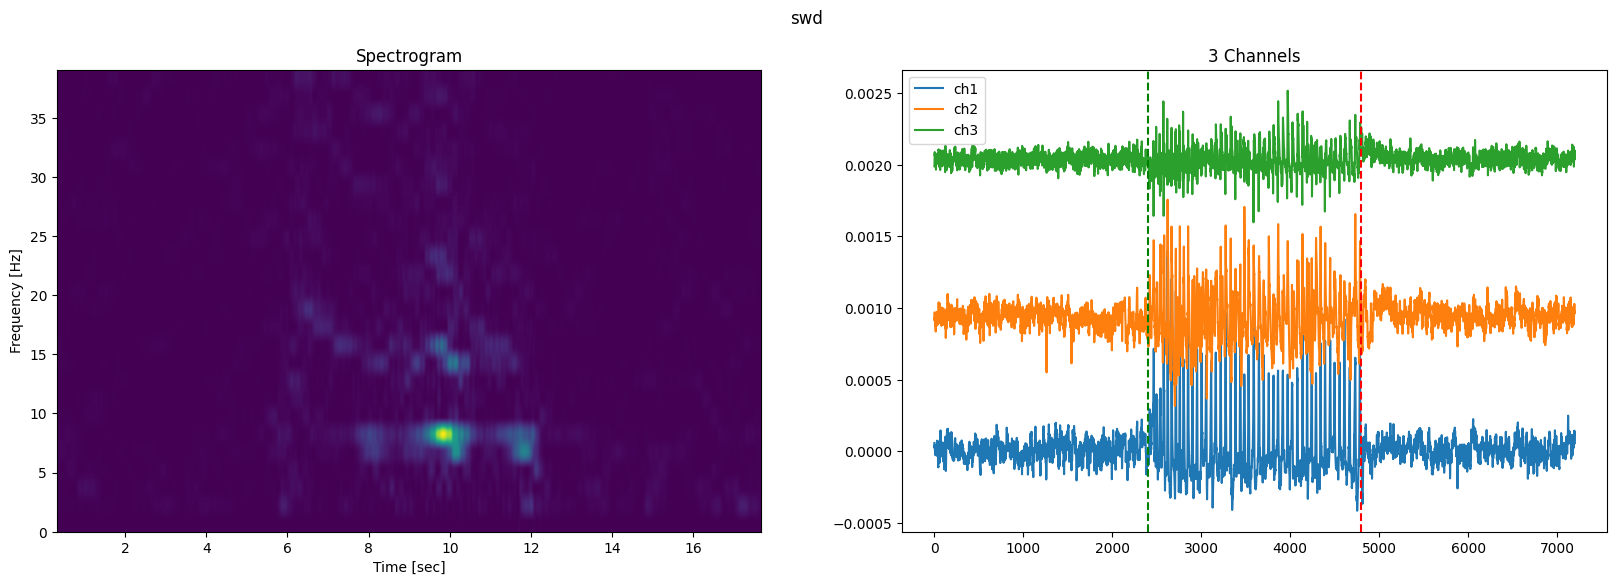

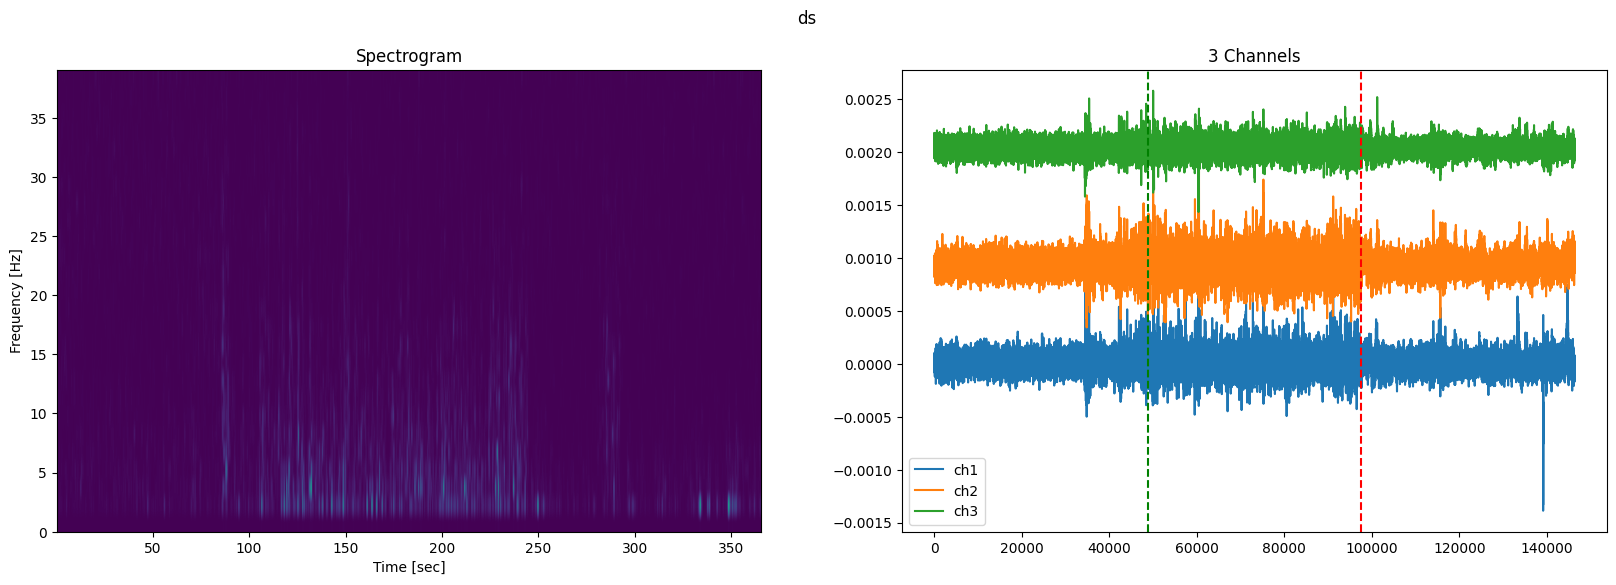

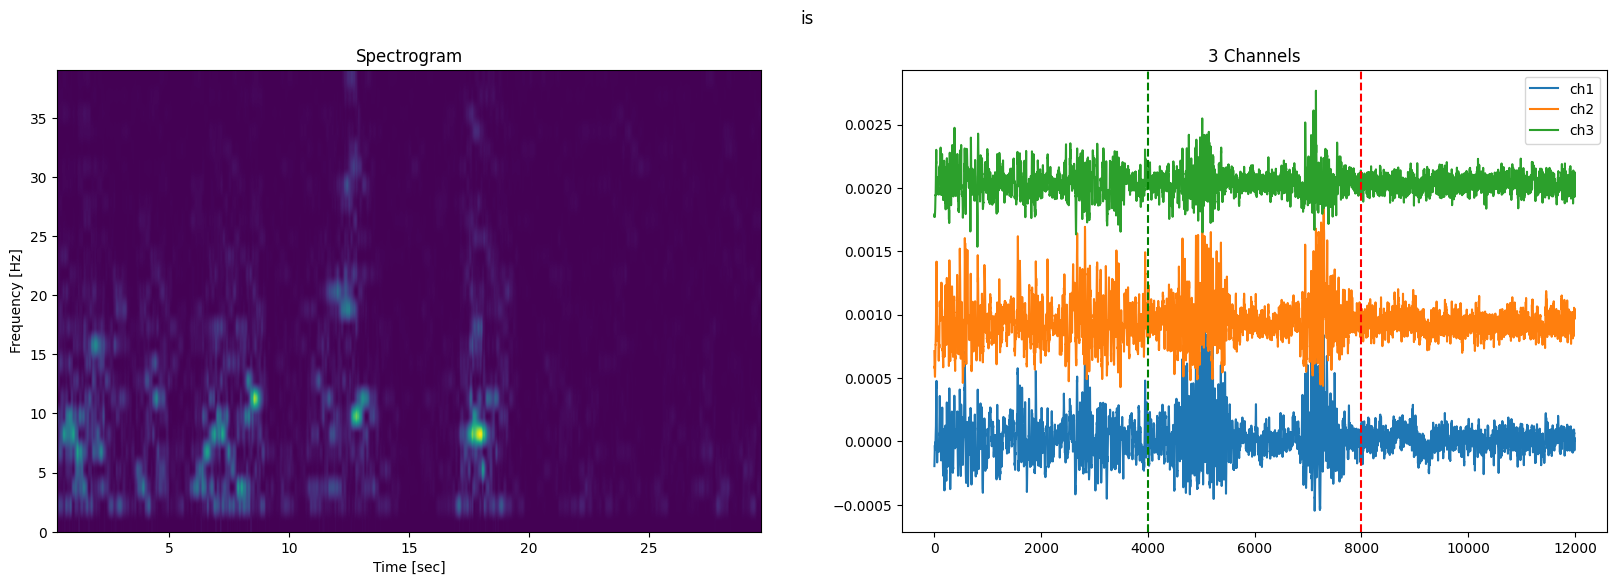

In [10]:
from scipy.signal import spectrogram
fs = 400
f_min = 0
f_max = 40

for event_type in event_types:
    event = choice(annotations[event_type])
    start = event[0]
    end = event[1]
    margin = (end - start)
    data_slice = data[:, start - margin:end + margin]
    
    ch1 = data_slice[0]
    ch2 = data_slice[1] + 0.001
    ch3 = data_slice[2] + 0.002
    
    ch = ch1
    
    f, t, Sxx = spectrogram(data_slice, fs, nperseg=256, noverlap=255)
    mask = (f >= f_min) & (f <= f_max)
    f = f[mask]
    Sxx = Sxx[:, mask, :]
    
    plt.figure(figsize=(20, 6))
    
    plt.subplot(121)
    plt.imshow(Sxx[2], aspect='auto', origin='lower', extent=[t[0], t[-1], f[0], f[-1]])
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title('Spectrogram')    
    
    plt.subplot(122)
    plt.plot(ch1, label='ch1')
    plt.plot(ch2, label='ch2')
    plt.plot(ch3, label='ch3')
    plt.axvline(margin, color='g', linestyle='--')
    plt.axvline(len(ch1) - margin, color='r', linestyle='--')
    plt.legend()
    plt.title('3 Channels')
    
    plt.suptitle(event_type)
    plt.show()

# Попытка использовать автоэнкодер

In [23]:
import torch
from tqdm import tqdm
import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn as nn

import torch.nn as nn
import torch.optim as optim

class EEGAutoEncoder(nn.Module):
    def __init__(self, input_size, latent_size):
        super(EEGAutoEncoder, self).__init__()
        
        self.latent_size = latent_size
        
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(16 * input_size, latent_size),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 16 * input_size),
            nn.ReLU(),
            nn.Unflatten(1, (16, input_size)),
            nn.ConvTranspose1d(16, 1, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
window_size = 400
latent_size = 16
input_size = window_size

model = EEGAutoEncoder(input_size, latent_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)

num_epochs = 3

data_normalized = (data - np.mean(data)) / np.std(data)

for epoch in range(num_epochs):
    running_loss = 0.0
    indices = range(0, data.shape[1] - window_size, 100)
    indices = np.random.permutation(indices)
    pbar = tqdm(indices, desc=f'Epoch {epoch+1}', position=0, leave=True)
    ind = 0
    
    batch = []
    
    for i in pbar:
        window = torch.tensor(data_normalized[0, i:i+window_size], dtype=torch.float32)
        batch.append(window.unsqueeze(0).unsqueeze(0))
        if len(batch) < 32:
            continue
        
        batch = torch.cat(batch, dim=0)
        outputs = model(batch)
        loss = criterion(outputs, batch)
        batch = []

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        ind += 1
        pbar.set_postfix({'loss': running_loss / ind})
    
torch.save(model.state_dict(), 'autoencoder.pth')

Epoch 3: 100%|██████████| 86400/86400 [00:32<00:00, 2666.62it/s, loss=0.405]


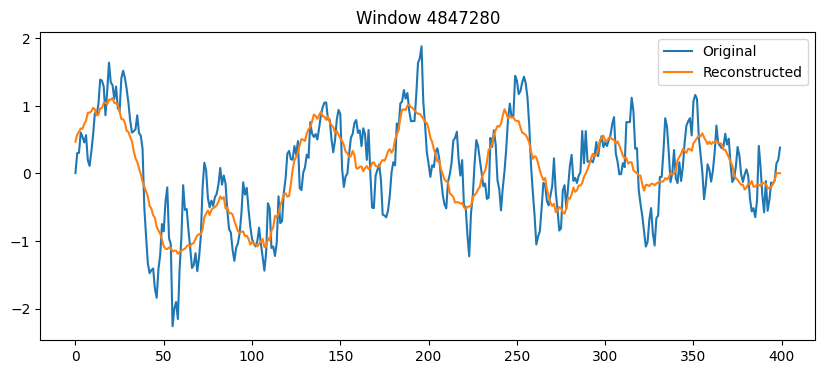

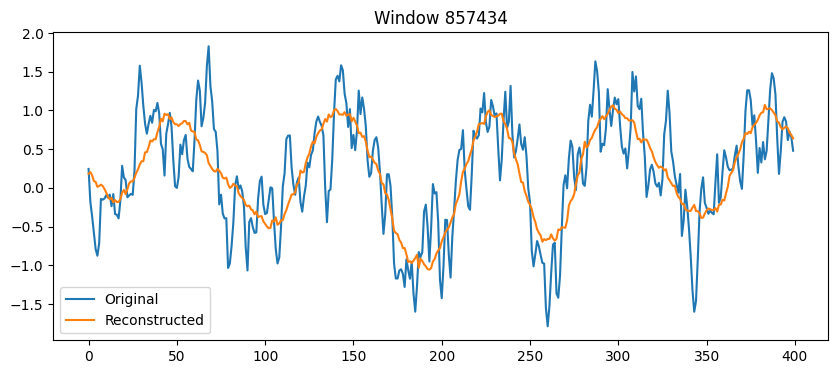

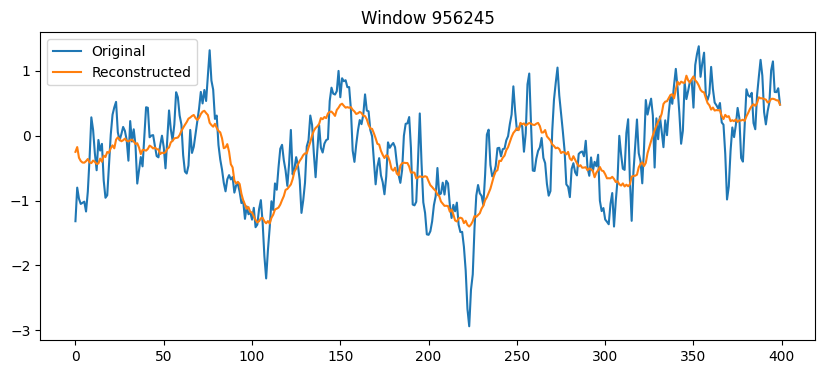

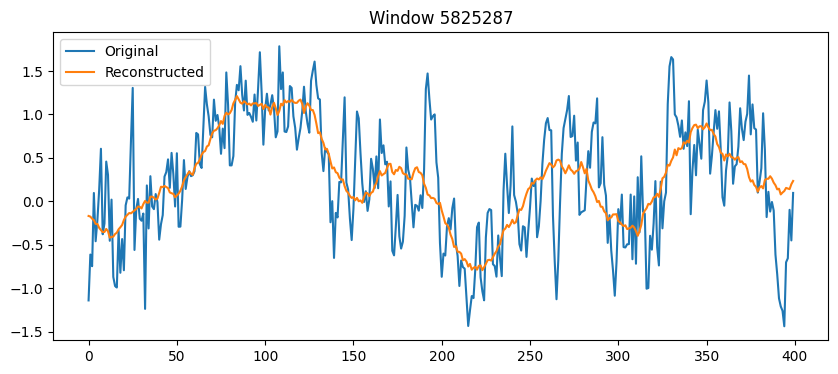

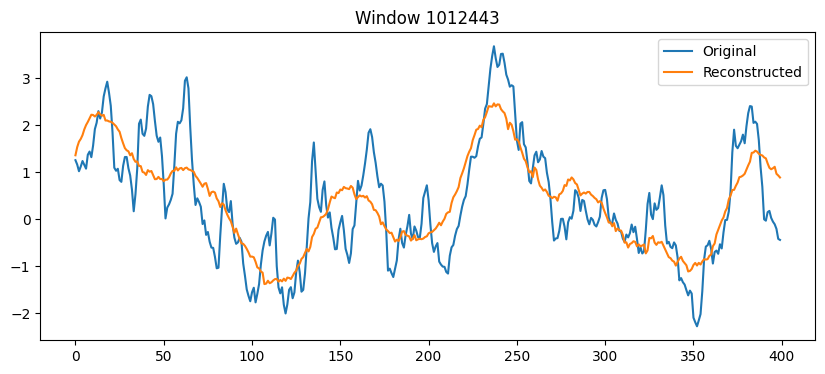

In [25]:
import matplotlib.pyplot as plt

num_windows = 5
window_indices = np.random.choice(range(data.shape[1] - window_size), num_windows)

for index in window_indices:
    original_window = data_normalized[0, index:index+window_size]
    original_window_tensor = torch.tensor(original_window, dtype=torch.float32)
    
    reconstructed_window_tensor = model(original_window_tensor.unsqueeze(0).unsqueeze(0))
    
    reconstructed_window = reconstructed_window_tensor.detach().numpy().flatten()
    
    plt.figure(figsize=(10, 4))
    plt.plot(original_window, label='Original')
    plt.plot(reconstructed_window, label='Reconstructed')
    plt.legend()
    plt.title(f'Window {index+1}')
    plt.show()

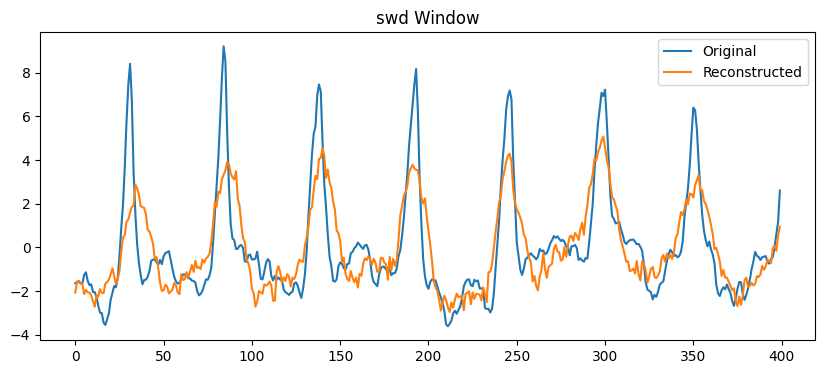

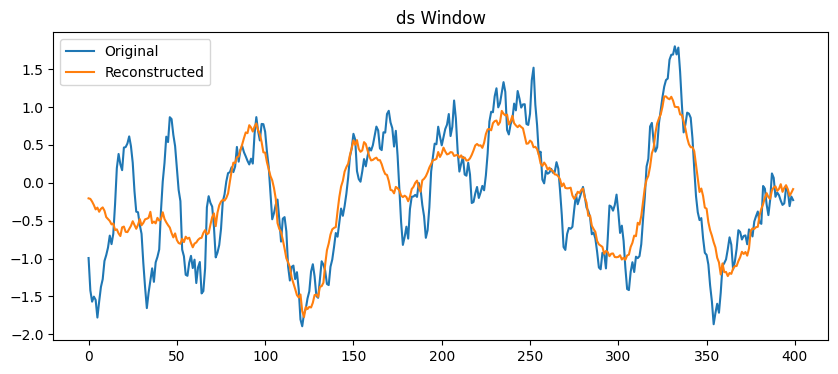

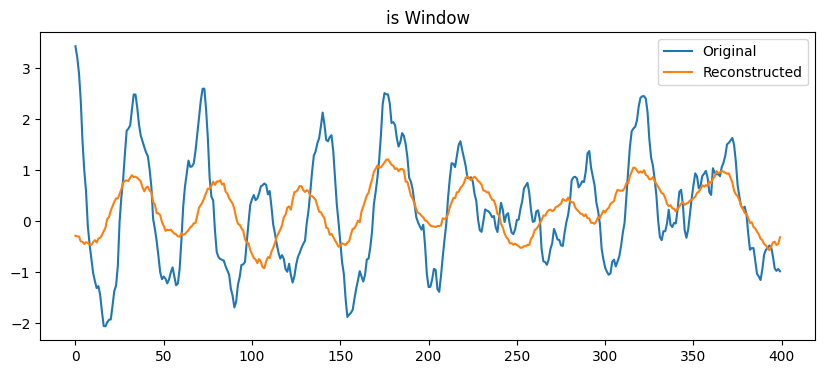

In [26]:
from PIL import Image

event_types = ['swd', 'ds', 'is']

for event_type in event_types:
    event_list = annotations[event_type]
    event = choice(event_list)
    
    start = event[0]
    end = event[1]
    
    start = np.random.randint(start, end - window_size)
    end = start + window_size
    
    original_window = data_normalized[0, start:end]
    
    original_window_tensor = torch.tensor(original_window, dtype=
                                          torch.float32).view(1, 1, -1)
    
    reconstructed_window_tensor = model(original_window_tensor)
    
    reconstructed_window = reconstructed_window_tensor.detach().numpy().flatten()
    
    plt.figure(figsize=(10, 4))
    plt.plot(original_window, label='Original')
    plt.plot(reconstructed_window, label='Reconstructed')
    plt.legend()
    plt.title(f'{event_type} Window')
    plt.show()

In [27]:
import numpy as np
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

embeds = []
events = []
for i in tqdm(range(0, data.shape[1] - window_size, 100)):
    window = data_normalized[0, i:i+window_size]
    window_tensor = torch.tensor(window, dtype=torch.float32).view(1, 1, -1)
    embed = model.encoder(window_tensor).detach().numpy()
    embeds.append(embed)
    
    for event_type in event_types:
        event_list = annotations[event_type]
        for event in event_list:
            if event[0] <= i < event[1] or event[0] < i + window_size <= event[1]:
                events.append(event_type)
                break
        else:
            continue
        break
    else:
        events.append('None')
        
    
embeds = np.array(embeds).reshape(-1, latent_size)

pca = PCA(n_components=2)
pca.fit(embeds)

embeds_pca = pca.transform(embeds)

colors = {'swd': 'r', 'ds': 'g', 'is': 'b', 'None': 'white'}
event_colors = [colors[event] for event in events]

100%|██████████| 86400/86400 [00:12<00:00, 6945.65it/s]


(19901, 2)


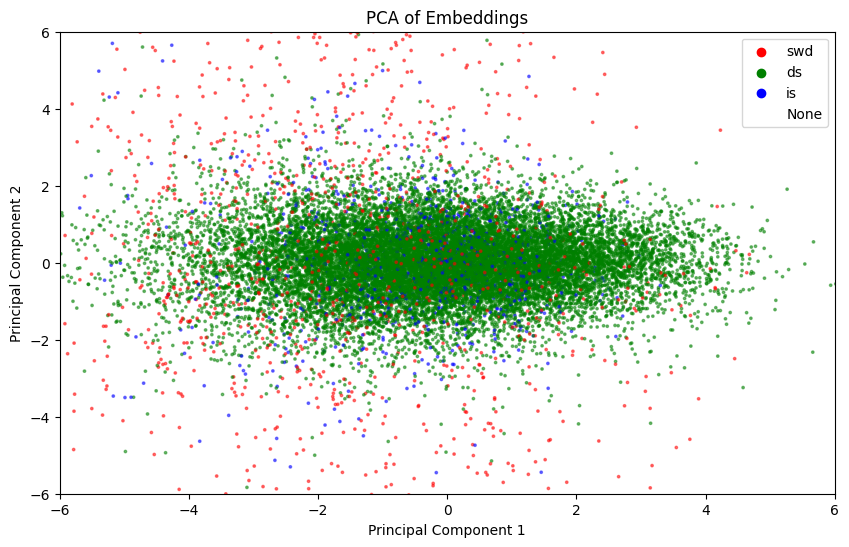

In [ ]:
colors = {'swd': 'r', 'ds': 'g', 'is': 'b', 'None': 'white'}
event_colors = [colors[event] for event in events if event != 'None']
embeds_pca_no_none = embeds_pca[np.array(events) != 'None', :]

print(embeds_pca_no_none.shape)

plt.figure(figsize=(10, 6))
plt.scatter(embeds_pca_no_none[:, 0], embeds_pca_no_none[:, 1], s=3, c=event_colors, alpha=.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.xlim(-7, 7)
plt.ylim(-7, 7)
plt.title('PCA of Embeddings')
for event_type, color in colors.items():
    plt.scatter([], [], color=color, label=event_type)
plt.legend()
plt.show()

In [53]:
X = embeds
y = [colors[event] for event in events]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           b       0.15      0.03      0.05       180
           g       0.70      0.70      0.70      3479
           r       0.77      0.74      0.75       299
       white       0.91      0.92      0.92     13322

    accuracy                           0.86     17280
   macro avg       0.63      0.60      0.61     17280
weighted avg       0.86      0.86      0.86     17280

